In [193]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [194]:
file_root = '/mnt/store1/oliverphilcox/3PCF_QPM/full_run.v02/'

r_bins = np.linspace(5,175,dat.f.bins)
ells = np.arange(dat.f.order+1)

In [195]:
good_mocks=[]
all_zeta = []
all_zeta_uncorr=[]
all_xi = []
gg=[]
for i in range(1,301):
    in_dat = file_root+'3pcf_output_%s.npz'%str(i).zfill(4)
    if os.path.exists(in_dat):
        gg.append(i)
        dat = np.load(in_dat)
        this_zeta = dat.f.zeta*pow(1.5,3)
        this_zeta_uncorr = dat.f.powerD*pow(1.5,3)
        
        #if i in bad_index:
        #    continue
        
        
        if not np.isnan(np.sum(this_zeta)):
            
            if np.abs(np.sum(this_zeta))>1e14:
                continue
            
            good_mocks.append(i)
            
            # normalize correctly
            for b1 in range(len(this_zeta)):
                for b2 in range(b1):
                    this_zeta[b1,b2,1:]*=this_zeta[b1,b2,0]
                    this_zeta_uncorr[b1,b2,1:]*=this_zeta_uncorr[b1,b2,0]
                    # by symmetry
                    this_zeta[b2,b1,:]=this_zeta[b1,b2,:]
                    this_zeta_uncorr[b2,b1,:]=this_zeta_uncorr[b1,b2,:]
                    
            all_zeta.append(this_zeta)
            all_zeta_uncorr.append(this_zeta_uncorr)
            all_xi.append(dat.f.xi*pow(1.5,2))
        else:
            os.remove(in_dat)
            
all_zeta = np.asarray(all_zeta)
all_zeta_uncorr = np.asarray(all_zeta_uncorr)
all_xi = np.asarray(all_xi)
n_mocks = len(good_mocks)
print("N_mocks = %d"%n_mocks)

N_mocks = 134


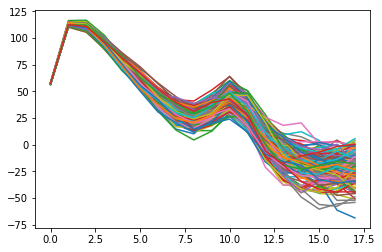

In [196]:
for i in range(n_mocks):
    plt.plot(r_bins**2*all_xi[i])

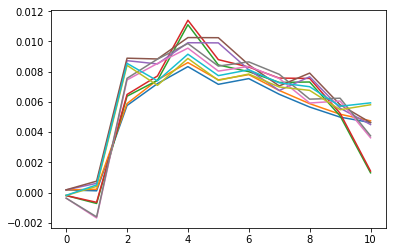

In [197]:
for i in range(5):#n_mocks):
    if i!=69:
        plt.plot(all_zeta[i][5,7,:])
        plt.plot(all_zeta_uncorr[i][5,7,:])


## Very different to old results?

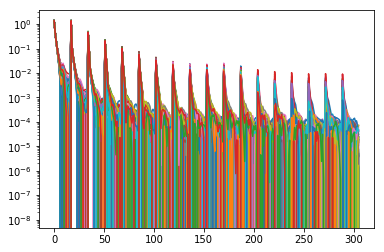

In [198]:
for i in range(n_mocks):
    this_dat=[]
    for j in range(n):
        for k in range(n):
            if j!=k:
                this_dat.append(all_zeta[i][j,k,0])
    plt.plot(this_dat)
plt.yscale('log')

In [199]:
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
n=len(r_min)
min_r_bin = 7

vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

zeta_compress = np.zeros([n_mocks,len(r_bins)-min_r_bin,dat.f.order+1])

for i in range(n_mocks):
    denom = np.zeros([len(r_bins)-min_r_bin])

    for b1 in range(min_r_bin,n):
        for b2 in range(3,b1-3):
            zeta_compress[i,b1-min_r_bin,:]+=all_zeta[i,b1,b2,:]*vol_r[b2]
            denom[b1-min_r_bin]+=vol_r[b2]
        zeta_compress[i,b1-min_r_bin,:]/=denom[b1-min_r_bin]

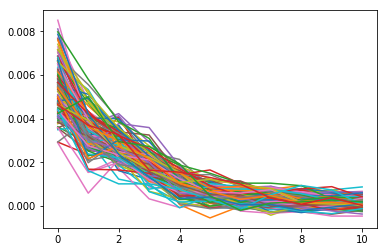

In [200]:
for i in range(n_mocks):
    plt.plot(zeta_compress[i,:,5])

Using single-mock errors


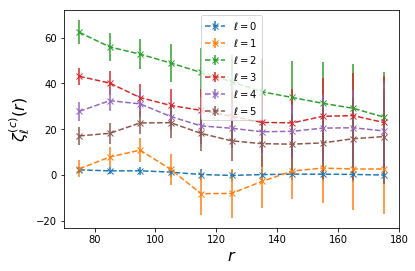

In [201]:
for l_i,ell in enumerate(ells[:6]):
    plt.errorbar(r_bins[min_r_bin:],(r_bins[min_r_bin:]/10.)**4*zeta_compress[:,:,l_i].mean(axis=0),
                 (r_bins[min_r_bin:]/10)**4.*zeta_compress[:,:,l_i].std(axis=0),label=r'$\ell=%d$'%(ell),
                marker='x',ls='--')
plt.legend()
plt.ylabel(r'$\zeta^{(c)}_\ell(r)$',fontsize=16)
plt.xlabel(r'$r$',fontsize=16)
print("Using single-mock errors")

### Compute Q ratio

<ErrorbarContainer object of 3 artists>

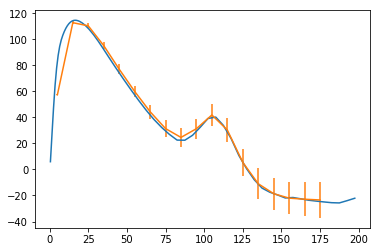

In [226]:
xi_r = np.genfromtxt('/mnt/store1/oliverphilcox/QPM_xi/QPM_mean.xi',max_rows=1)
xi_dat = np.genfromtxt('/mnt/store1/oliverphilcox/QPM_xi/QPM_mean.xi',skip_header=2)

from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(xi_r,xi_r**2*xi_dat.mean(axis=1),s=1)
xi_fun = lambda r: spl(r)/r**2

plt.plot(xi_r,xi_r**2*xi_fun(xi_r))
plt.errorbar(r_bins,r_bins**2*all_xi.mean(axis=0),yerr=r_bins**2*all_xi.std(axis=0))

In [228]:
from scipy.special import legendre

mu_arr = np.arange(-1.,1.,0.05)

all_Q = np.zeros([n,n,len(mu_arr)])

for b1 in range(n):
    for b2 in range(n):
        if b1==b2:
            continue
        r1 = r_bins[b1]
        r2 = r_bins[b2]

        this_zeta = all_zeta.mean(axis=0)[b1,b2]

        r3_arr = np.sqrt(r2**2+r1**2-2*r1*r2*mu_arr)

        xi_12 = xi_fun(r1)*xi_fun(r2)*np.ones_like(r3_arr)

        ells = np.arange(max_l+1)

        this_zeta_mu = np.zeros(len(mu_arr))

        for ell in ells:
            this_zeta_mu+=legendre(ell)(mu_arr)*this_zeta[ell]

        this_Q = this_zeta_mu/(xi_12+xi_fun(r1)*xi_fun(r3_arr)+xi_fun(r2)*xi_fun(r3_arr))
        
        all_Q[b1,b2]=this_Q

In [230]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

Q_compress = np.zeros([n-min_r_bin,len(mu_arr)])

denom = np.zeros([n-min_r_bin])

for b1 in range(min_r_bin,n):
    for b2 in range(3,b1-3):
        Q_compress[b1-min_r_bin,:]+=all_Q[b1,b2,:]*vol_r[b2]
        denom[b1-min_r_bin]+=vol_r[b2]
    Q_compress[b1-min_r_bin,:]/=denom[b1-min_r_bin]

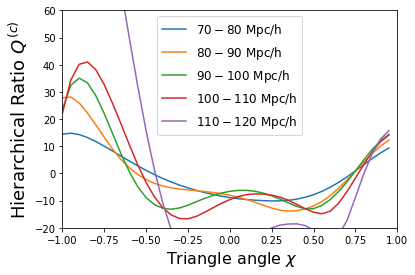

In [236]:
for i in range(len(Q_compress)-6):
    plt.plot(mu_arr,Q_compress[i],label=r'$%d-%d$ Mpc/h'%(r_min[min_r_bin+i],r_min[min_r_bin+i+1]))
plt.legend(fontsize=12)
plt.ylim([-20,60])
plt.xlim([-1,1])
plt.ylabel(r'Hierarchical Ratio $Q^{(c)}$',fontsize=18);plt.xlabel(r' Triangle angle $\chi$',fontsize=16);

# NB: Why are the higher multipoles much bigger than SE paper??

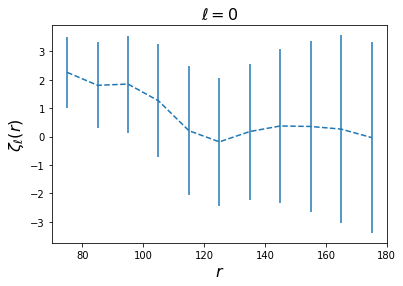

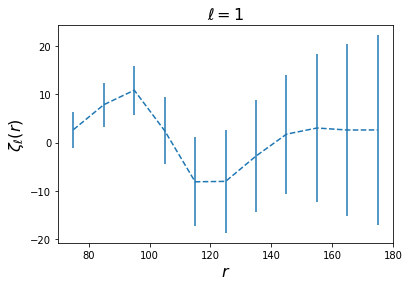

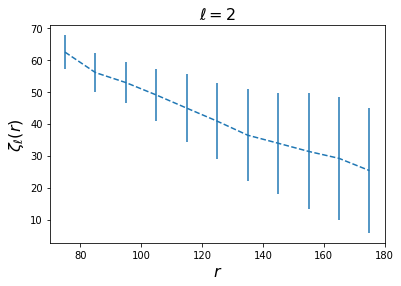

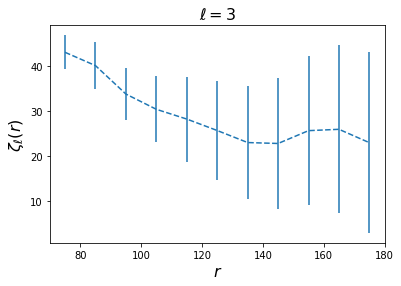

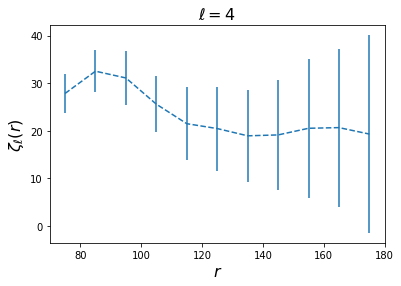

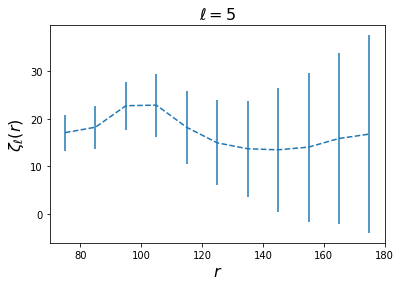

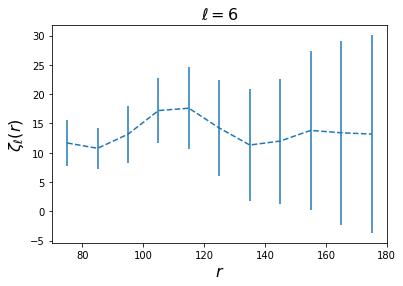

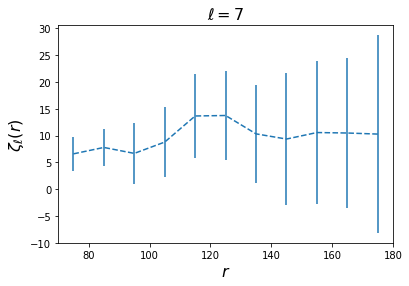

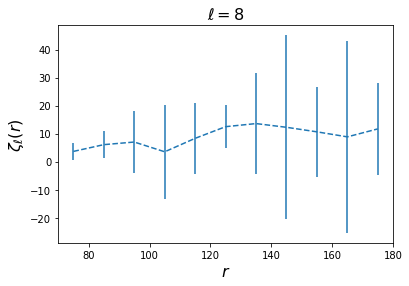

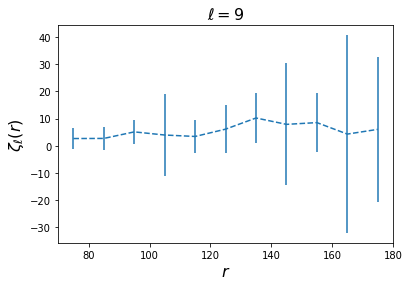

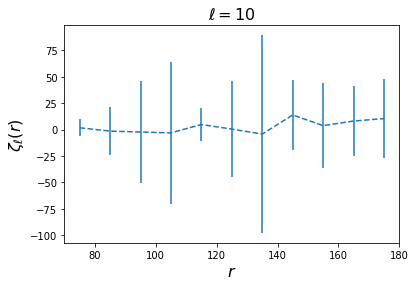

In [202]:
for l_i in ells:
    plt.figure()
    x_dat = r_bins[min_r_bin:]
    y_dat=zeta_compress[:,:,l_i].mean(axis=0)
    y_err=zeta_compress[:,:,l_i].std(axis=0)
    plt.errorbar(x_dat,(x_dat/10.)**4*y_dat,
                 (r_bins[min_r_bin:]/10)**4.*y_err,label=r'$\ell=%d$'%(l_i),
                marker='',ls='--')
    plt.title(r'$\ell = %d$'%l_i,fontsize=16)
    plt.xlabel(r'$r$',fontsize=16)
    plt.ylabel(r'$\zeta_\ell(r)$',fontsize=16)
#plt.legend()

In [203]:
zeta_compress_ravel=[]
for i in range(n_mocks):
    zeta_compress_ravel.append(zeta_compress[i].T.ravel())
zeta_mean = np.mean(np.asarray(zeta_compress_ravel),axis=0)

In [204]:
cov = np.zeros([len(zeta_compress_ravel[0]),len(zeta_compress_ravel[0])])
for i in range(n_mocks):
    diff = zeta_compress_ravel[i]-zeta_mean
    cov+=np.matmul(diff.reshape(-1,1),diff.reshape(1,-1))
cov/=n_mocks-1

In [205]:
red = np.zeros_like(cov)
for i in range(len(cov)):
    for j in range(len(cov)):
        red[i,j]=cov[i,j]/np.sqrt(cov[i,i]*cov[j,j])

## QPM 3PCF Covariance Matrix (250 mocks)

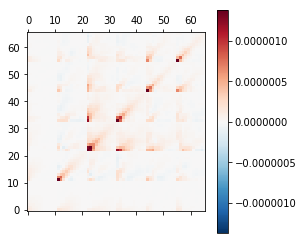

In [206]:
mat=cov
max_l = 5
vmax=np.percentile(mat[:(max_l+1)*11,:(max_l+1)*11].ravel(),99.9)
plt.matshow(cov,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
plt.xlim([-0.5,(max_l+1)*11-0.5])
plt.ylim([-0.5,(max_l+1)*11-0.5])
plt.colorbar();

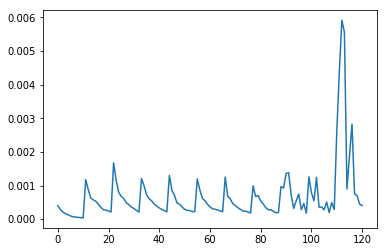

In [207]:
plt.plot(np.sqrt(np.diag(cov)))

In [210]:
np.savez('/mnt/store1/oliverphilcox/3PCF_SE_2/data_cov_matrix.npz',n_mocks=n_mocks,
        cov=cov)

## Reduced Covariance Matrix

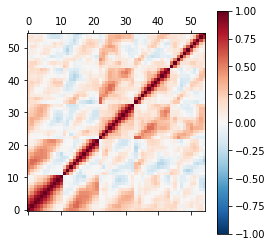

In [211]:
plt.matshow(red,cmap=cm.RdBu_r,vmax=1,vmin=-1)
plt.xlim([-0.5,55-0.5])
plt.ylim([-0.5,55-0.5])
plt.colorbar();

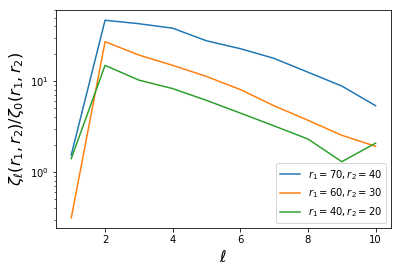

In [212]:
inds = [[7,4],[6,3],[4,2]]
for ind in inds:
    plt.plot(ells[1:],all_zeta.mean(axis=0)[ind[0],ind[1],1:]/all_zeta.mean(axis=0)[ind[0],ind[1],0],
            label=r'$r_1 = %d, r_2 = %d$'%(ind[0]*10,ind[1]*10))
plt.ylabel(r'$\zeta_\ell(r_1,r_2)/\zeta_0(r_1,r_2)$',fontsize=16)
plt.xlabel(r'$\ell$',fontsize=16)
plt.legend();
plt.yscale('log')

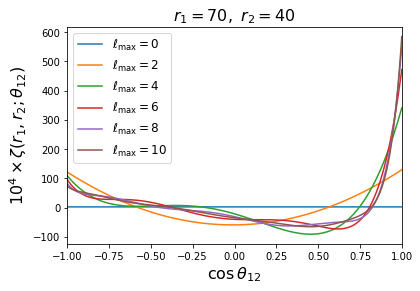

In [213]:
from scipy.special import legendre

for ell_max in [0,2,4,6,8,10]:
    these_ell = np.arange(0,ell_max+1)
    mus = np.arange(-1,1,0.001)
    ddat=[]
    for ell in these_ell:
        ddat.append(legendre(ell)(mus)*all_zeta.mean(axis=0)[7,4][ell])
    dddat = np.sum(np.asarray(ddat),axis=0)
    plt.plot(mus,1e4*dddat,label=r'$\ell_\mathrm{max} = %d$'%ell_max)
plt.legend(fontsize=12);
plt.xlim([-1,1])
plt.xlabel(r'$\cos\,{\theta_{12}}$',fontsize=16)
plt.ylabel(r'$10^4\times \zeta(r_1,r_2;\theta_{12})$',fontsize=16)
plt.title(r'$r_1 = 70,\,\,r_2 = 40$',fontsize=16);

<ErrorbarContainer object of 3 artists>

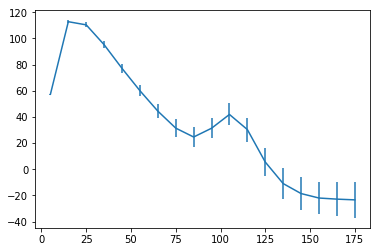

In [214]:
plt.errorbar(r_bins,all_xi.mean(axis=0)*r_bins**2,all_xi.std(axis=0)*r_bins**2,marker='')